# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 5 - SUPPORT VECTOR MACHINES**

---

## **SETUP**

In [1]:
# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [30]:
# Common libraries.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Default settings for matplotlib.
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("grid", linestyle="dotted")
plt.rc("axes", grid=True)

In [3]:
# Create a directory for matplotlib images.
from pathlib import Path

IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)

---

## **LINEAR SVM CLASSIFICATION**

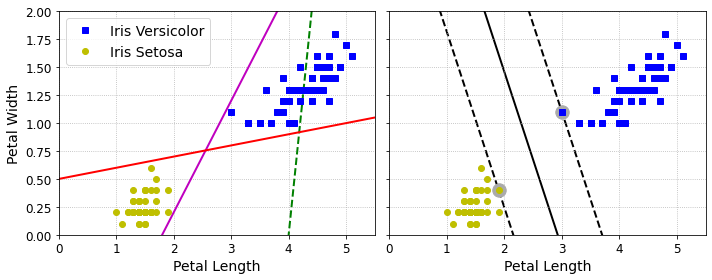

In [4]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values  # type: ignore
y = iris.target  # type: ignore

setosa_or_versicolor = ((y == 0) | (y == 1))
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

svm_clf = SVC(kernel="linear", C=np.inf)
svm_clf.fit(X, y)

# Bad models.
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]  # [0] because it's [[]]
    b = svm_clf.intercept_[0] #
    
    # At the decision boundary: w0*x0 + w1*x1 + b = 0  =>  x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]
    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_
    
    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolor="#AAA", zorder=-1)
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris Versicolor")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris Setosa")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])

plt.sca(ax2)
plot_svc_decision_boundary(svm_clf, 0, 5.5)    
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")
plt.xlabel("Petal Length")
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification")
plt.show()


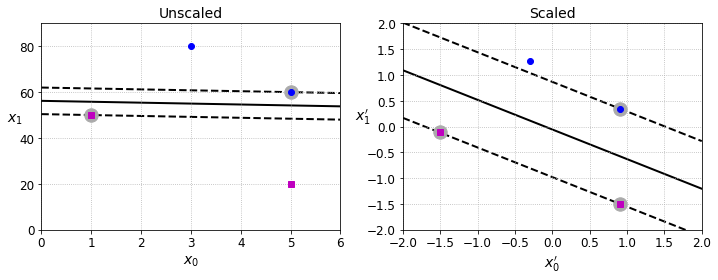

In [6]:
from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(Xs[:, 0][ys == 1], Xs[:, 1][ys == 1], "bo")
plt.plot(Xs[:, 0][ys == 0], Xs[:, 1][ys == 0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])

plt.subplot(1, 2, 2)
plt.plot(X_scaled[:, 0][ys == 1], X_scaled[:, 1][ys == 1], "bo")
plt.plot(X_scaled[:, 0][ys == 0], X_scaled[:, 1][ys == 0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x_0'$")
plt.ylabel("$x_1'$", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales")
plt.show()

---

## **SOFT MARGIN CLASSIFICATION**

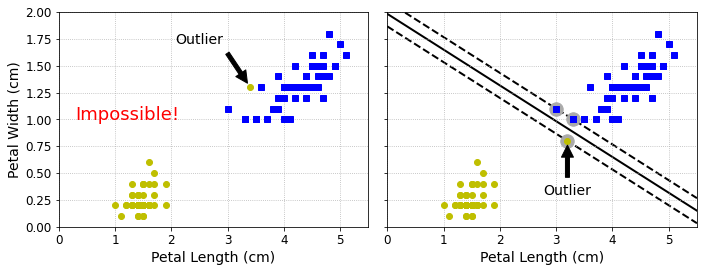

In [31]:
# Sometimes the hard margin classification is not possible.
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=np.inf)
svm_clf2.fit(Xo2, yo2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plt.plot(Xo1[:, 0][yo1 == 1], Xo1[:, 1][yo1 == 1], "bs")
plt.plot(Xo1[:, 0][yo1 == 0], Xo1[:, 1][yo1 == 0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
    fontsize=14,
)
plt.axis([0, 5.5, 0, 2])

plt.sca(ax2)
plt.plot(Xo2[:, 0][yo2 == 1], Xo2[:, 1][yo2 == 1], "bs")
plt.plot(Xo2[:, 0][yo2 == 0], Xo2[:, 1][yo2 == 0], "yo")

plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal Length (cm)")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.3),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
    fontsize=14,
)
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers")
plt.show()

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

X = iris.data[["petal length (cm)", "petal width (cm)"]].values  # type: ignore
y = (iris.target == 2)  # type: ignore | Iris Virginica.

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [61]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [62]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

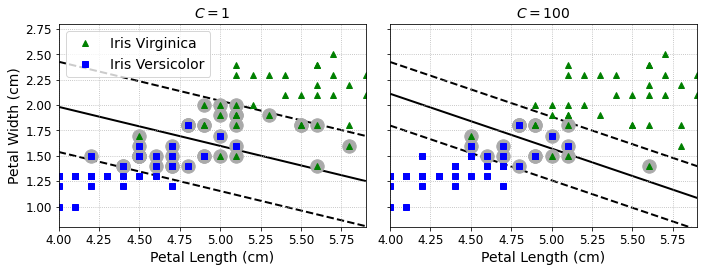

In [71]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters.
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])  # type: ignore
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])  # type: ignore
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically).
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]  # type: ignore  
svm_clf2.support_vectors_ = X[support_vectors_idx2]  # type: ignore

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plt.plot(X[:, 0][y == True], X[:, 1][y == True], "g^", label="Iris Virginica")
plt.plot(X[:, 0][y == False], X[:, 1][y == False], "bs", label="Iris Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(ax2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal Length (cm)")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization")
plt.show()

---

## **NONLINEAR SVM CLASSIFICATION**

### **1. POLYNOMIAL FEATURES**

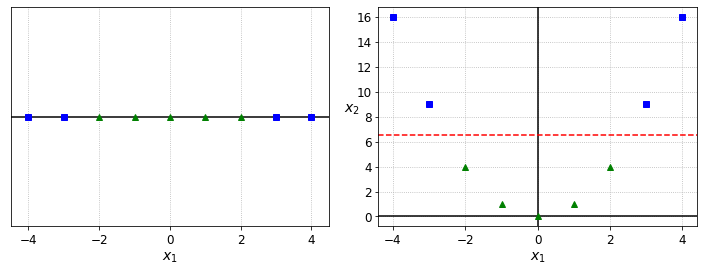

In [88]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D ** 2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.axhline(y=0, color="k")
plt.plot(X1D[:, 0][y == 0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y == 1], np.zeros(5), "g^")
plt.gca().yaxis.set_ticks([])  # plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(1, 2, 2)
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.plot(X2D[:, 0][y == 0], X2D[:, 1][y == 0], "bs")
plt.plot(X2D[:, 0][y == 1], X2D[:, 1][y == 1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axhline(y=6.5, linestyle="dashed", color="red")

save_fig("higher_dimensions")
plt.show()

In [95]:
# Train LinearSVC to predict samples from the moons dataset.

from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42),
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

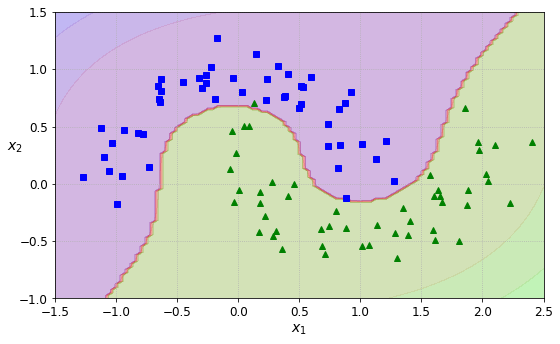

In [115]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    plt.axis(axes)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # type: ignore
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)  # type: ignore

plt.figure(figsize=(8, 5))
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc")
plt.show()

### **2. POLYNOMIAL KERNEL**

In [118]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=3, coef0=1, C=5)  # coef0 - impact of poly degrees.
)
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

[]

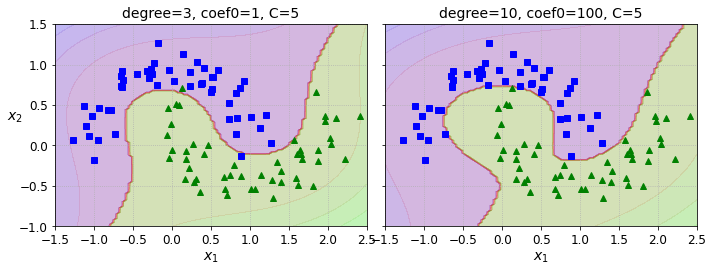

In [121]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(ax2)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc")
plt.plot()

### **3. SIMILARITY FEATURES**

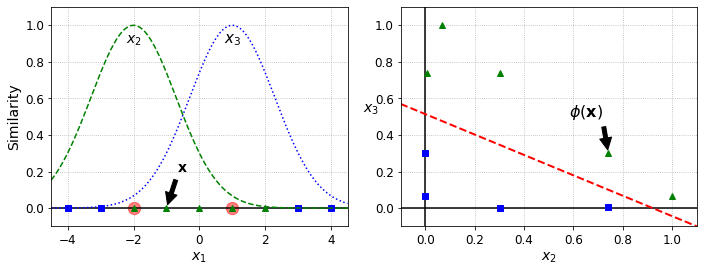

In [151]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1) ** 2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.axhline(y=0, color="k")
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, color="red")
plt.plot(X1D[:, 0][yk == 0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk == 1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r"$\mathbf{x}$",
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.2),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
    fontsize=14,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=14)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$", rotation=0)
plt.annotate(
    r"$\phi\left(\mathbf{x}\right)$",
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=2)
plt.axis([-0.1, 1.1, -0.1, 1.1])

save_fig("kernel_method")
plt.show()


### **4. GAUSSIAN RBF KERNEL**

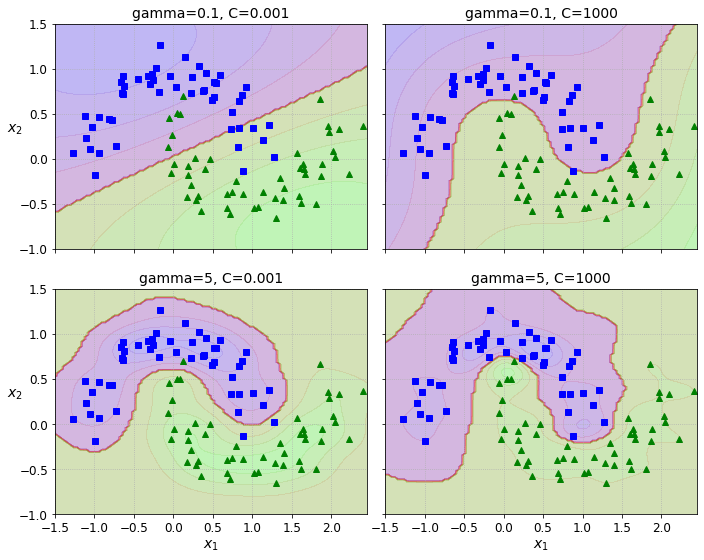

In [152]:
from sklearn.svm import SVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)  # type: ignore
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])  # type: ignore
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"{gamma=}, {C=}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
        
save_fig("moons_rbf_svc")
plt.show()

---

## **SVM REGRESSION**

### **1. LINEAR REGRESSION**

In [187]:
from sklearn.svm import LinearSVR

# Linear dataset with a small gaussian noise.
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg1 = make_pipeline(StandardScaler(), LinearSVR(epsilon=0.5, random_state=42))
svm_reg1.fit(X, y)

svm_reg2 = make_pipeline(StandardScaler(), LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=1.2, random_state=42))])

In [188]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon  # Remember that svm_reg is a pipeline with estimator.
    off_margin = (np.abs(y - y_pred) >= epsilon)
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180,
                facecolors="#AAA", zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)
 

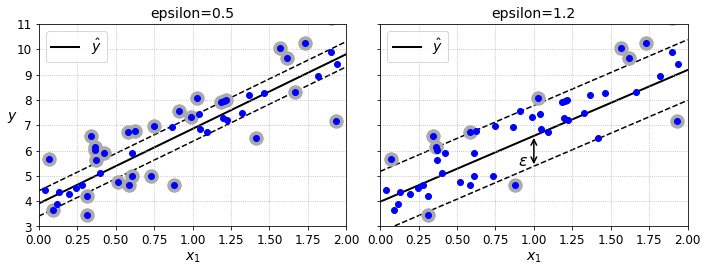

In [189]:
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)  # type: ignore
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)  # type: ignore

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg1[-1].epsilon}")  # type: ignore
plt.ylabel("$y$", rotation=0)

plt.sca(ax2)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")  # type: ignore
plt.annotate(
    "",
    xy=(eps_x1, eps_y_pred),
    xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),  # type: ignore
    textcoords="data",
    arrowprops={
        "arrowstyle": "<->",
        "linewidth": 1.5,
    },
)
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)

save_fig("svm_regression")
plt.show()


### **2. POLYNOMIAL REGRESSION**

In [190]:
from sklearn.svm import SVR

# Simple quadratic dataset.
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) * 0.1

svm_poly_reg1 = make_pipeline(StandardScaler(),
                              SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg1.fit(X, y)

svm_poly_reg2 = make_pipeline(StandardScaler(), SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, degree=2, kernel='poly'))])

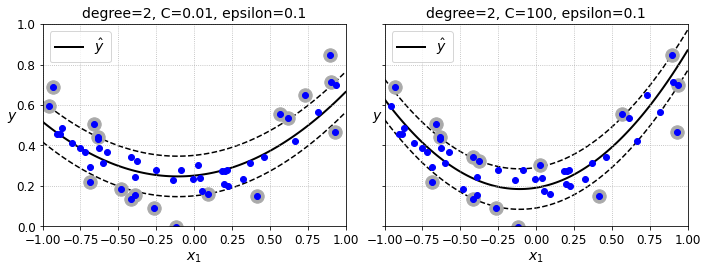

In [195]:
svm_poly_reg1.support_ = find_support_vectors(svm_poly_reg1, X, y)  # type: ignore
svm_poly_reg2.support_ = find_support_vectors(svm_poly_reg2, X, y)  # type: ignore

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg1[-1].degree}, "  # type: ignore
          f"C={svm_poly_reg1[-1].C}, "  # type: ignore
          f"epsilon={svm_poly_reg1[-1].epsilon}")  # type: ignore
plt.ylabel("$y$", rotation=0)

plt.sca(ax2)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "  # type: ignore
          f"C={svm_poly_reg2[-1].C}, "  # type: ignore
          f"epsilon={svm_poly_reg2[-1].epsilon}")  # type: ignore
plt.ylabel("$y$", rotation=0)

save_fig("svm_with_polynomial_kernel")
plt.show()

---

## **UNDER THE HOOD**

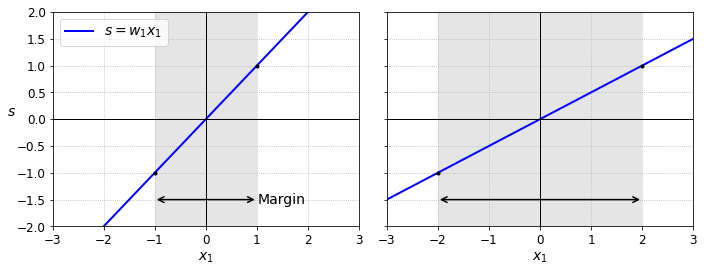

In [211]:
from matplotlib.patches import Rectangle

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=None):
    if not x1_lim:
        x1_lim = [-3, 3]
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    half_margin = 1 / w
    
    plt.plot(x1, y, "b-", linewidth=2, label=r"$s = w_1 x_1$")
    plt.axhline(y=0, color="k", linewidth=1)
    plt.axvline(x=0, color="k", linewidth=1)
    
    rect = Rectangle((-half_margin, -2), 2 * half_margin, 4,
                     edgecolor="none", facecolor="gray", alpha=0.2)
    plt.gca().add_patch(rect)

    plt.plot(half_margin, 1, "k.")
    plt.plot(-half_margin, -1, "k.")
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel("$x_1$")
    
    if ylabel:
        plt.ylabel("$s$", rotation=0, labelpad=5)
        plt.legend()
        plt.text(1.02, -1.5, "Margin", ha="left", va="center", color="k")
    
    plt.annotate("", xy=(-half_margin, -1.5), xytext=(half_margin, -1.5),
                 arrowprops={"ec": "k", "arrowstyle": "<->", "linewidth": 1.5})
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_2D_decision_function(1, 0)

plt.sca(ax2)
plot_2D_decision_function(0.5, 0, ylabel=False)

save_fig("small_vs_large_margin")
plt.show()

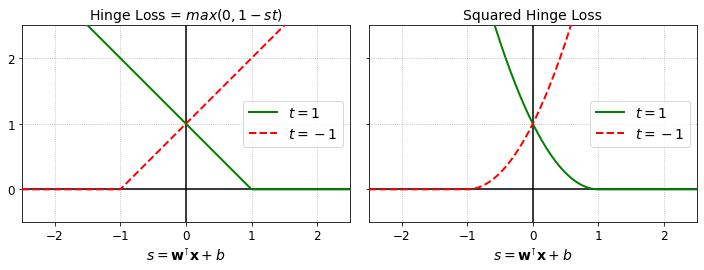

In [222]:
s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge Loss = $max(0, 1 - st)$", "Squared Hinge Loss")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

for ax, loss_pos, loss_neg, title in zip(
    axes, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

save_fig("hinge_plot")
plt.show()

---